Initial cost: 546.055
Final cost: 0.00718513
Max absolute difference: 0.00921673


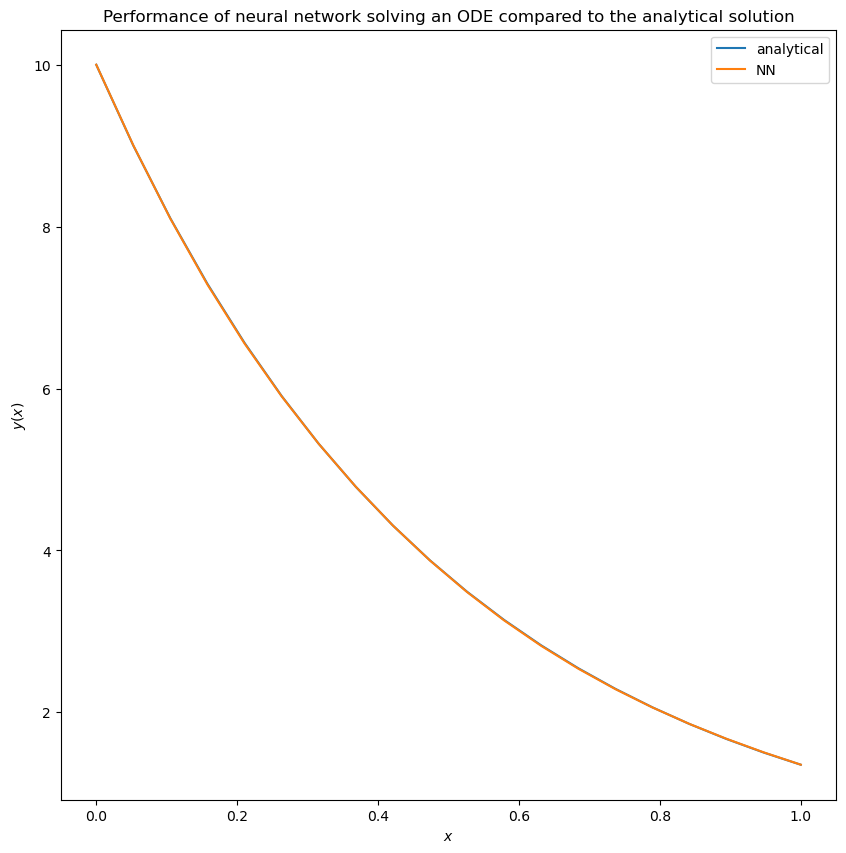

In [1]:
%matplotlib inline

import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

M = 1.
En = 0.963
l = 5.



def sigmoid(z):
    return 1/(1 + np.exp(-z))


# Assuming one input, hidden, and output layer
def neural_network(params, x):

    # Find the weights (including and biases) for the hidden and output layer.
    # Assume that params is a list of parameters for each layer.
    # The biases are the first element for each array in params,
    # and the weights are the remaning elements in each array in params.

    P_hidden = params[0]
    P_output = params[1]

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    
    ## Hidden layer:
    # Add a row of ones to include bias
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)

    z_hidden = np.matmul(P_hidden, x_input)
    x_hidden = sigmoid(z_hidden)

    
    ## Output layer:
    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)

    z_output = np.matmul(P_output, x_hidden)
    x_output = z_output # No activation function

    return x_output


# The trial solution using the deep neural network:
def y_trial(x,params, y0 = 10):
    return y0 + x*neural_network(params,x)


# The right side of the ODE:
def y(x, y_trial, gamma = 2):
    return -gamma*y_trial


# The cost function:
def cost_function(P, x):

    # Evaluate the trial function with the current parameters P
    y_t = y_trial(x,P)

    # Find the derivative w.r.t x of the neural network
    #d_net_out = elementwise_grad(neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_y_t = elementwise_grad(y_trial,0)(x,P)

    # The right side of the ODE
    func = y(x, y_t)

    err_sqr = (d_y_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)



# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases

    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )

    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included

    P = [p0, p1]

    print('Initial cost: %g'%cost_function(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad =  cost_function_grad(P, x)

        P[0] = P[0] - 10*lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]

    print('Final cost: %g'%cost_function(P, x))

    return P


def y_analytic(x, gamma = 2, y0 = 10):
    return y0*np.exp(-gamma*x)



# Solve the given problem
if __name__ == '__main__':
    # Set seed such that the weight are initialized
    # with same weights and biases for every run.
    npr.seed(413)

    ## Decide the vales of arguments to the function to solve
    N = 20
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = 10
    num_iter = 20000
    lmb = 0.001

    # Use the network
    P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)

    # Print the deviation from the trial solution and true solution
    res = y_trial(x,P)
    res_analytical = y_analytic(x)

    print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

    # Plot the results
    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','NN'])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y(x)$')
    plt.show()

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt


M = 1.
En = 0.963
l = 5.



def sigmoid(z):
    return 1/(1 + np.exp(-z))

# The neural network with one input layer and one output layer,
# but with number of hidden layers specified by the user.
def deep_neural_network1(deep_params, x):
    # N_hlayers is the number of hidden layers

    N_hlayers = np.size(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hlayers):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

# The neural network with one input layer and one output layer,
# but with number of hidden layers specified by the user.
def deep_neural_network2(deep_params, x):
    # N_hlayers is the number of hidden layers

    N_hlayers = np.size(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hlayers):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

# The neural network with one input layer and one output layer,
# but with number of hidden layers specified by the user.
def deep_neural_network3(deep_params, x):
    # N_hlayers is the number of hidden layers

    N_hlayers = np.size(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hlayers):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output


####################




# The trial solution using the deep neural network:
def y_trial_deep1(x,params, y0 = 15):
    return y0 + x*deep_neural_network1(params, x)

# The trial solution using the deep neural network:
def y_trial_deep2(x,params, y0 = 0):
    return y0 + x*deep_neural_network2(params, x)


# The trial solution using the deep neural network:
def y_trial_deep3(x,params, y0 = 0):
    return y0 + x*deep_neural_network3(params, x)



######



# The right side of the ODE:
def y(x, y_trial, gamma = 2):
    return 2*x #-gamma*y_trial

# The right side of the ODE:
def y(x, y_trial, gamma = 2):
    return 2*x #-gamma*y_trial

# The right side of the ODE:
def y(x, y_trial, gamma = 2):
    return 2*x #-gamma*y_trial


##########


# The same cost function as before, but calls deep_neural_network instead.
def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    y_t = y_trial_deep(x,P)

    # Find the derivative w.r.t x of the neural network
    #d_net_out = elementwise_grad(deep_neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_y_t = elementwise_grad(y_trial_deep,0)(x,P)

    # The right side of the ODE
    func = y(x, y_t)

    err_sqr = (d_y_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)





# Solve the exponential decay ODE using neural network with one input and one output layer,
# but with specified number of hidden layers from the user.
def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # The number of elements in the list num_hidden_neurons thus represents
    # the number of hidden layers.

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weights and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P





def y_analytic(x, gamma = 2, y0 = 10):
    return x**2  + 10#y0*np.exp(-gamma*x)




# Solve the given problem
if __name__ == '__main__':
    npr.seed(413)

    ## Decide the vales of arguments to the function to solve
    N = 15
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = np.array([50,20])
    num_iter = 20000
    lmb = 0.001

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    res = y_trial_deep(x,P)
    res_analytical = y_analytic(x)

    plt.figure(figsize=(10,10))

    plt.title('Performance of a deep neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','DNN'])
    plt.ylabel(r'$y(x)$')
    plt.xlabel(r'$x$')
    plt.show()

In [2]:
import deepxde as dde
import numpy as np

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



Compiling model...
Building feed-forward neural network...
'build' took 0.020198 s

'compile' took 0.134073 s

Initializing variables...


/Users/eduard/miniforge3/envs/ashcat/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/eduard/miniforge3/envs/ashcat/lib/python3.9/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.14e-01, 1.11e-01, 0.00e+00, 1.00e+00]    [2.19e-01, 1.14e-01, 0.00e+00, 1.00e+00]    [1.12e+00]    
1000      [6.06e-03, 8.57e-03, 1.50e-06, 2.25e-04]    [6.77e-03, 9.21e-03, 1.50e-06, 2.25e-04]    [8.91e-01]    
2000      [5.41e-03, 5.25e-03, 1.82e-07, 1.55e-04]    [5.99e-03, 5.76e-03, 1.82e-07, 1.55e-04]    [8.69e-01]    
3000      [3.55e-03, 3.30e-03, 5.43e-08, 5.75e-05]    [3.84e-03, 3.61e-03, 5.43e-08, 5.75e-05]    [7.84e-01]    
4000      [2.65e-03, 2.92e-03, 5.23e-08, 3.46e-05]    [2.77e-03, 3.22e-03, 5.23e-08, 3.46e-05]    [7.09e-01]    
5000      [2.42e-03, 2.56e-03, 2.71e-09, 8.35e-08]    [2.64e-03, 2.81e-03, 2.71e-09, 8.35e-08]    [6.60e-01]    
6000      [1.98e-03, 1.98e-03, 1.24e-06, 2.24e-05]    [2.13e-03, 2.15e-03, 1.24e-06, 2.24e-05]    [5.80e-01]    
7000      [1.41e-03, 1.20e-03, 1.53e-07, 1.19e-05]    [1.42e-03, 1.35e-03, 1.

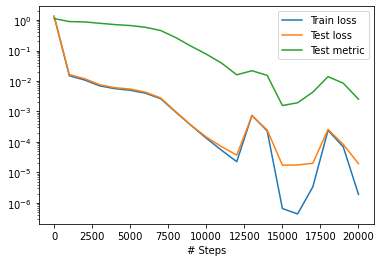

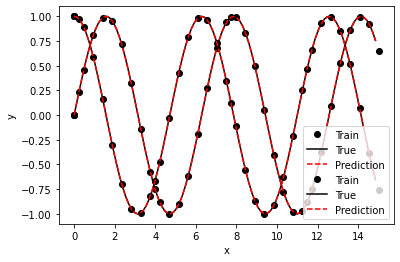

In [8]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np

M = 1.
En = 0.963
l = 5.


def ode_system(x, y):
    """ODE system.
    y1 = r
    y2 = phi
    y3 = p
    """
    # Most backends
    r, phi, p = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dr_x = dde.grad.jacobian(y, x, i=0)
    dphi_x = dde.grad.jacobian(y, x, i=1)
    dp_x = dde.grad.jacobian(y, x, i=2)
    # Backend jax
    # y_val, y_fn = y
    # y1, y2 = y_val[:, 0:1], y_val[:, 1:]
    # dy1_x, _ = dde.grad.jacobian(y, x, i=0)
    # dy2_x, _ = dde.grad.jacobian(y, x, i=1)
    return [dr_x - (1-2*M/r)*p, dphi_x - l/r**2, , dp_x + M*En**2/(r-2*M)**2 + M*p**2/r**2 - l**2/r**3]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 15)
ic1 = dde.icbc.IC(geom, lambda x: 15., boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0., boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda x: 0., boundary, component=2)

data = dde.data.PDE(geom, ode_system, [ic1, ic2, ic3], 35, 2, solution=func, num_test=100)

layer_size = [1] + [100] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)